# Import All The Neccessary Libraries For The Project

In [1]:
#-------Import Dependencies-------#
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from time import time
from PIL import ImageDraw
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc
from scipy import ndimage
# from scipy.ndimage.interpolation import zoom

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from tensorflow.keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# Function For Visualizing Training Results

In [22]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [3]:
import os
import cv2


# dataset_path = '/Downloads/trypophobia-detection-master/trypophobia-detection-master/new_scripts/trypo'
train_norm  = '/Deep Learning/skrips/train/norm'
train_trypo = '/Deep Learning/skrips/train/trypo'
valid_norm  = '/Deep Learning/skrips/valid/norm'
valid_trypo = '/Deep Learning/skrips/valid/trypo'

train_data_ratio = 1.0 # ratio of training data

# train_norm_path = os.path.join(dataset_path, train_norm)
train_norm_filelist = os.listdir(train_norm)
train_norm_filelist = train_norm_filelist[:int(train_data_ratio * len(train_norm_filelist))]

# train_trypo_path = os.path.join(dataset_path, train_trypo)
train_trypo_filelist = os.listdir(train_trypo)
train_trypo_filelist = train_trypo_filelist[:int(train_data_ratio * len(train_trypo_filelist))]

# valid_norm_path = os.path.join(dataset_path, valid_norm)
valid_norm_filelist = os.listdir(valid_norm)

# valid_trypo_path = os.path.join(dataset_path, valid_trypo)
valid_trypo_filelist = os.listdir(valid_trypo)

def get_images(file_list, path):
    return [cv2.imread(os.path.join(path, image)) for image in file_list]

train_norm_images = get_images(train_norm_filelist, train_norm)
train_trypo_images = get_images(train_trypo_filelist, train_trypo)
valid_norm_images = get_images(valid_norm_filelist, valid_norm)
valid_trypo_images = get_images(valid_trypo_filelist, valid_trypo)

print(train_norm_images[0])
print(train_trypo_images[0])
print(valid_norm_images[0])
print(valid_trypo_images[0])

[[[ 12  14  11]
  [ 13  15  16]
  [ 12  12  13]
  ...
  [ 96 119 131]
  [ 98 117 135]
  [ 99 119 136]]

 [[ 11  13   8]
  [ 15  15  15]
  [ 11  11  10]
  ...
  [106 124 141]
  [101 124 139]
  [101 122 138]]

 [[ 13  13  13]
  [ 14  14  14]
  [ 19  18  19]
  ...
  [106 122 137]
  [108 124 141]
  [108 124 141]]

 ...

 [[ 58  72  72]
  [ 60  65  64]
  [ 54  59  59]
  ...
  [140 135 127]
  [137 134 129]
  [128 129 124]]

 [[ 43  52  56]
  [ 42  52  53]
  [ 37  45  44]
  ...
  [131 136 134]
  [138 138 132]
  [140 139 129]]

 [[ 47  56  63]
  [ 44  56  59]
  [ 37  49  51]
  ...
  [130 136 136]
  [123 133 142]
  [131 132 137]]]
[[[255 255 254]
  [111 125 125]
  [ 96 114 115]
  ...
  [ 93  83  95]
  [ 90  77  95]
  [231 231 231]]

 [[255 255 254]
  [ 85  90  93]
  [ 76 108  91]
  ...
  [ 91  90 106]
  [177 173 183]
  [255 255 255]]

 [[173 188 179]
  [ 66  83  80]
  [ 65  72  82]
  ...
  [253 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[ 68  67  73]
  [184 183 179]
  [113 117 118]
  ..

# Preprocessing

In [7]:
# train_dir = '/Deep Learning/skrips/train'
# val_dir = '/Deep Learning/skrips/valid'

In [5]:
import matplotlib.pyplot as plt

def get_display_image(image):
    plt.figure(figsize=(2, 2))
    plt.imshow(image[:, :, [2, 1, 0]])
    plt.show()

In [5]:
train  = '/Deep Learning/skrips/train'
valid  = '/Deep Learning/skrips/valid'

In [6]:
augs = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,  
    zoom_range=0.2,        
    horizontal_flip=True)  

train_gen = augs.flow_from_directory(
    train,
    target_size = (128,128),
    batch_size=32,
    class_mode = 'binary',
    shuffle=True)

val_gen = augs.flow_from_directory(
    valid,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary')

Found 15884 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# The Sequential Model

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 128, 128, 8)       0         
 ng2D)                                                           
                                                                 
 conv2d_60 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 conv2d_61 (Conv2D)          (None, 128, 128, 8)       1160      
                                                                 
 batch_normalization_27 (Ba  (None, 128, 128, 8)       32        
 tchNormalization)                                               
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 64, 64, 8)       

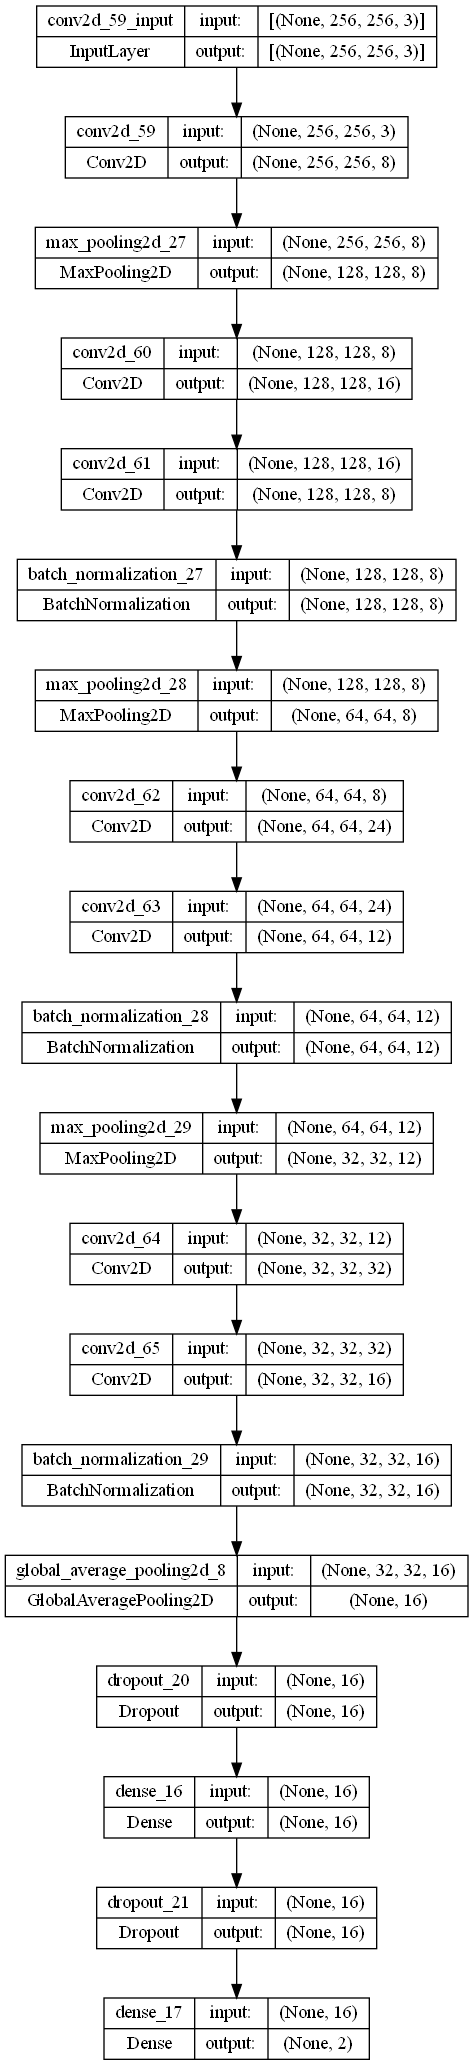

In [19]:

model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu',padding='same', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(24, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(12, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(16))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# model = Sequential()
# model.add(Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(2,2))
# model.add(Dropout(0.2))
# model.add(Conv2D(64,(3,3),activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(2,2))
# model.add(Dropout(0.2))
# model.add(Conv2D(128,(3,3),activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(2,2))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dropout(0.5))
# model.add(Dense(1,activation='sigmoid'))
# model.summary()

# SVG(model_to_dot(model).create(prog='dot', format='svg'))
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Callbacks

In [20]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    verbose=1,
    save_freq='epoch',
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    # period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1,
    mode='auto'
)
# tensorboard = TensorBoard(
#     log_dir = './logs',
#     histogram_freq=0,
#     batch_size=16,
#     write_graph=True,
#     write_grads=True,
#     write_images=False,
# )

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,earlystop]

# Model Training

In [24]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
    
train = model.fit(
    train_gen, 
    steps_per_epoch  = 100, 
    validation_data  = val_gen,
    validation_steps = 100,
    epochs           = 30,
    verbose          = 1,
    validation_split = 0.1,
    callbacks=callbacks
)

Epoch 1/30


ValueError: in user code:

    File "c:\Users\Hani\.conda\envs\09040620070DATAMINING2023\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Hani\.conda\envs\09040620070DATAMINING2023\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Hani\.conda\envs\09040620070DATAMINING2023\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Hani\.conda\envs\09040620070DATAMINING2023\Lib\site-packages\keras\src\engine\training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Hani\.conda\envs\09040620070DATAMINING2023\Lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Hani\.conda\envs\09040620070DATAMINING2023\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Hani\.conda\envs\09040620070DATAMINING2023\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Hani\.conda\envs\09040620070DATAMINING2023\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Hani\.conda\envs\09040620070DATAMINING2023\Lib\site-packages\keras\src\losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\Hani\.conda\envs\09040620070DATAMINING2023\Lib\site-packages\keras\src\backend.py", line 5824, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


# Evaluate The Model And Save The Weights Of The Model

KeyError: 'val_loss'

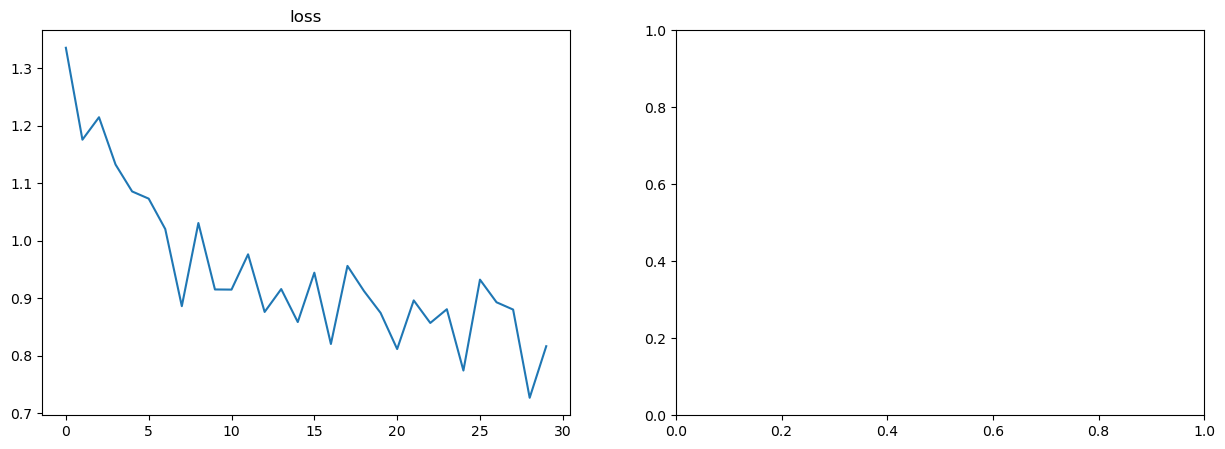

In [ ]:
show_final_history(history)
model.load_weights('./base.model')
model_score = model.evaluate_generator(val_gen,steps=100)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("trypophobia.h5")
print("Weights Saved")